<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2023-05-02 12:39:14--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2023-05-02 12:39:14--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2023-05-02 12:39:14--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['patti-smith.txt',
 'beatles.txt',
 'nursery_rhymes.txt',
 'ludacris.txt',
 'radiohead.txt',
 'al-green.txt',
 'kanye-west.txt',
 'johnny-cash.txt',
 'nicki-minaj.txt',
 'lady-gaga.txt',
 'eminem.txt',
 'jimi-hendrix.txt',
 'britney-spears.txt',
 'kanye.txt',
 'janisjoplin.txt',
 'drake.txt',
 'dr-seuss.txt',
 'nickelback.txt',
 'blink-182.txt',
 'r-kelly.txt',
 'dolly-parton.txt',
 'amy-winehouse.txt',
 'lil-wayne.txt',
 'bob-dylan.txt',
 'cake.txt',
 'leonard-cohen.txt',
 'alicia-keys.txt',
 'bruno-mars.txt',
 'dj-khaled.txt',
 'nirvana.txt',
 'paul-simon.txt',
 'bob-marley.txt',
 'Lil_Wayne.txt',
 'notorious_big.txt',
 'dickinson.txt',
 'adele.txt',
 'Kanye_West.txt',
 'notorious-big.txt',
 'joni-mitchell.txt',
 'lin-manuel-miranda.txt',
 'michael-jackson.txt',
 'lorde.txt',
 'bruce-springsteen.txt',
 'bjork.txt',
 'disney.txt',
 'prince.txt',
 'bieber.txt',
 'rihanna.txt',
 'missy-elliott.txt']

In [29]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
# Utilizamos el dataset de canciones de Kayne West (tiene un corpus un poco mayor)
df = pd.read_csv('songs_dataset/kanye-west.txt', sep='/n', header=None)
df.head()

<ipython-input-29-7c781694902b>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/kanye-west.txt', sep='/n', header=None)


,0
0,Let the suicide doors up
1,I threw suicides on the tour bus
2,I threw suicides on the private jet
3,You know what that mean Im fly to death
4,I step in Def Jam buildin like Im the shit


In [30]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 6191


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [31]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [32]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Let the suicide doors up'

In [33]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['let', 'the', 'suicide', 'doors', 'up']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [34]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [35]:
# Demos un vistazo
sentence_tokens[:4]

[['let', 'the', 'suicide', 'doors', 'up'],
 ['i', 'threw', 'suicides', 'on', 'the', 'tour', 'bus'],
 ['i', 'threw', 'suicides', 'on', 'the', 'private', 'jet'],
 ['you', 'know', 'what', 'that', 'mean', 'im', 'fly', 'to', 'death']]

In [36]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [37]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['let', 'the', 'suicide', 'doors']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [38]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [39]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[1, 2, 3, 4]]

In [42]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

1


In [43]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

4


In [44]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'let': 1, 'the': 2, 'suicide': 3, 'doors': 4}


In [45]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'let': 1, 'doors': 1, 'suicide': 1, 'the': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [46]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                              Let the suicide doors up
1                      I threw suicides on the tour bus
2                   I threw suicides on the private jet
3               You know what that mean Im fly to death
4            I step in Def Jam buildin like Im the shit
5             Tell em give me fifty million or Ima quit
6       Most rappers taste level aint at my waist level
7             Turn up the bass til its upinyoface level
8         Dont do no press but I get the most press kit
9     Plus yo my bitch make your bitch look like Pre...
10           Somethin bout Mary she gone off that molly
11             Now the whole party is melted like Dal√≠
12                     Now everybody is movin they body
13         Dont sell me apartment Ill move in the lobby
14            Niggas is loiterin just to feel important
15            You gon see lawyers and niggas in Jordans
Name: 0, dtype: object

In [47]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Let the suicide doors up I threw suicides on the tour bus I threw suicides on the private jet You know what that mean Im fly to death I step in Def Jam buildin like Im the shit Tell em give me fifty million or Ima quit Most rappers taste level aint at my waist level Turn up the bass til its upinyoface level Dont do no press but I get the most press kit Plus yo my bitch make your bitch look like Precious Somethin bout Mary she gone off that molly Now the whole party is melted like Dal√≠ Now everybody is movin they body Dont sell me apartment Ill move in the lobby Niggas is loiterin just to feel important You gon see lawyers and niggas in Jordans She said Ye can we get married at the mall I said Look you need to crawl fore you ball Come and meet me in the bathroom stall And show me why you deserve to have it all Ball so hard That shit cray aint it Jay What she order fish filet Your whip so cold ‚Äì this old thing Act like youll ever be around mothafuckas like this again Bougie girl grab

In [48]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['let',
 'the',
 'suicide',
 'doors',
 'up',
 'i',
 'threw',
 'suicides',
 'on',
 'the',
 'tour',
 'bus',
 'i',
 'threw',
 'suicides',
 'on',
 'the',
 'private',
 'jet',
 'you']

In [49]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 51398


In [50]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [51]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['let', 'the', 'suicide', 'doors'],
 ['the', 'suicide', 'doors', 'up'],
 ['suicide', 'doors', 'up', 'i'],
 ['doors', 'up', 'i', 'threw'],
 ['up', 'i', 'threw', 'suicides'],
 ['i', 'threw', 'suicides', 'on'],
 ['threw', 'suicides', 'on', 'the'],
 ['suicides', 'on', 'the', 'tour'],
 ['on', 'the', 'tour', 'bus'],
 ['the', 'tour', 'bus', 'i'],
 ['tour', 'bus', 'i', 'threw'],
 ['bus', 'i', 'threw', 'suicides'],
 ['i', 'threw', 'suicides', 'on'],
 ['threw', 'suicides', 'on', 'the'],
 ['suicides', 'on', 'the', 'private'],
 ['on', 'the', 'private', 'jet'],
 ['the', 'private', 'jet', 'you'],
 ['private', 'jet', 'you', 'know'],
 ['jet', 'you', 'know', 'what'],
 ['you', 'know', 'what', 'that']]

In [52]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[77, 1, 1342, 718],
 [1, 1342, 718, 19],
 [1342, 718, 19, 2],
 [718, 19, 2, 1099],
 [19, 2, 1099, 1744],
 [2, 1099, 1744, 14],
 [1099, 1744, 14, 1],
 [1744, 14, 1, 501],
 [14, 1, 501, 928],
 [1, 501, 928, 2],
 [501, 928, 2, 1099],
 [928, 2, 1099, 1744],
 [2, 1099, 1744, 14],
 [1099, 1744, 14, 1],
 [1744, 14, 1, 1100],
 [14, 1, 1100, 1101],
 [1, 1100, 1101, 3],
 [1100, 1101, 3, 26],
 [1101, 3, 26, 38],
 [3, 26, 38, 9]]

In [53]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 51394


### 3 - Input y target

In [54]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [55]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [56]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [57]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(51394, 3)
(51394,)


In [58]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'i',
 3: 'you',
 4: 'a',
 5: 'and',
 6: 'to',
 7: 'my',
 8: 'in',
 9: 'that',
 10: 'me',
 11: 'it',
 12: 'im',
 13: 'like',
 14: 'on',
 15: 'we',
 16: 'they',
 17: 'your',
 18: 'of',
 19: 'up',
 20: 'so',
 21: 'but',
 22: 'she',
 23: 'got',
 24: 'with',
 25: 'is',
 26: 'know',
 27: 'get',
 28: 'dont',
 29: 'this',
 30: 'be',
 31: 'now',
 32: 'for',
 33: 'just',
 34: 'all',
 35: 'aint',
 36: 'was',
 37: 'when',
 38: 'what',
 39: 'her',
 40: 'if',
 41: 'at',
 42: 'its',
 43: 'out',
 44: 'he',
 45: 'no',
 46: 'thats',
 47: 'do',
 48: 'niggas',
 49: 'cause',
 50: 'say',
 51: 'back',
 52: 'man',
 53: 'shit',
 54: 'from',
 55: 'go',
 56: 'nigga',
 57: 'see',
 58: 'how',
 59: 'make',
 60: 'cant',
 61: 'more',
 62: 'right',
 63: 'some',
 64: 'off',
 65: 'girl',
 66: 'said',
 67: 'need',
 68: 'have',
 69: 'not',
 70: 'never',
 71: 'had',
 72: 'as',
 73: 'then',
 74: 'can',
 75: 'love',
 76: 'one',
 77: 'let',
 78: 'way',
 79: 'about',
 80: 'yeah',
 81: 'why',
 82: 'take',
 83: 'b

In [61]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6166

In [63]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(51394, 6166)

### 4 - Entrenar el modelo

In [65]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [66]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

6166

In [67]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              30835     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6166)              203478    
                                                                 
Total params: 287,337
Trainable params: 287,337
Non-trai

In [68]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1285/1285 [==============================] - 31s 15ms/step - loss: 6.8104 - accuracy: 0.0378 - val_loss: 6.7676 - val_accuracy: 0.0367
Epoch 2/50
1285/1285 [==============================] - 12s 10ms/step - loss: 6.4507 - accuracy: 0.0389 - val_loss: 6.7776 - val_accuracy: 0.0367
Epoch 3/50
1285/1285 [==============================] - 12s 9ms/step - loss: 6.3394 - accuracy: 0.0391 - val_loss: 6.8786 - val_accuracy: 0.0367
Epoch 4/50
1285/1285 [==============================] - 12s 10ms/step - loss: 6.2473 - accuracy: 0.0449 - val_loss: 6.8839 - val_accuracy: 0.0383
Epoch 5/50
1285/1285 [==============================] - 15s 12ms/step - loss: 6.1143 - accuracy: 0.0480 - val_loss: 6.9367 - val_accuracy: 0.0424
Epoch 6/50
1285/1285 [==============================] - 13s 10ms/step - loss: 5.9727 - accuracy: 0.0522 - val_loss: 6.9750 - val_accuracy: 0.0427
Epoch 7/50
1285/1285 [==============================] - 17s 13ms/step - loss: 5.8677 - accuracy: 0.0550 - val_loss: 7.1020 - 

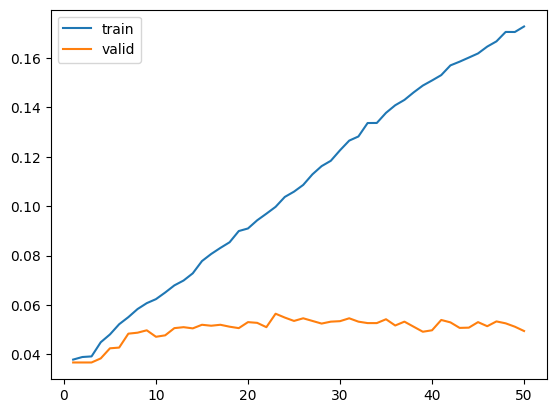

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [70]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:

In [77]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    print("Texto ingresado:", human_text,"- Predicción:", out_word)
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 22ms/step
Texto ingresado: Bam bam bam - Predicción: you
1/1 [==============================] - 0s 19ms/step
Texto ingresado: Gets the people - Predicción: with
1/1 [==============================] - 0s 20ms/step
Texto ingresado: Talk and talk - Predicción: the
1/1 [==============================] - 0s 20ms/step
Texto ingresado: In the night - Predicción: a
1/1 [==============================] - 0s 19ms/step
Texto ingresado: No one knows - Predicción: i
1/1 [==============================] - 0s 21ms/step
Texto ingresado: You are now - Predicción: the
1/1 [==============================] - 0s 18ms/step
Texto ingresado: let me into - Predicción: tinted
1/1 [==============================] - 0s 18ms/step
Texto ingresado: How could you - Predicción: this
1/1 [==============================] - 0s 31ms/step
Texto ingresado: friend look like - Predicción: 
1/1 [==============================] - 0s 20ms/step
Texto ingresado: Tom Cruise on - Predicción:

### 7 - Conclusiones
- Se observó en las métricas parciales que el modelo entrenado no estaba generalizando de forma correcta
- En las primeras pruebas de predicción ingresando textos por la interfaz se obtuvieron resultados bastante pobres, no completó estribillos o frases repetitivas como era esperado.
- Sin embargo, la mayoría de las veces la predicción tenía bastante sentido
- Se podría modificar la arquitectura, agregando capas o neuronaes, etc y entrenar mayor cantidad de épocas para ver si mejoran los resultados
